# Ciclo de Rankine

Estudio de un ciclo ideal de Rankine básico (sin recalentamiento). Datos de partida:

* Temperatura del agua a la entrada del boiler: 26,85 ºC (300 K)
* Temperatura del vapor a la entrada de la turbina: 626,85 ºC (900 K)
* Presión a la entrada del boiler: 10 kPa
* Presión a la entrada de la turbina: 10 MPa
* Flujo de vapor: 20 kg/s

Eficiencias de los equipos: como es el ciclo ideal, de momento las dejamos a 1. Pero dejaremos preparado el código para añadir las eficiencias más tarde.

In [4]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Definición de funciones

def bomba(w, p_salida, rendimiento):
    h_pre = w.h
    s_pre = w.s
    w.SP = s_pre, p_salida
    h_isen = w.h
    w_b_isentropico = h_isen - h_pre
    w_b_real = w_b_isentropico / rendimiento
    h_post = h_pre + w_b_real
    w.HP = h_post, p_salida
    print('Trabajo isentropico (bomba): {} J/kg'.format(w_b_isentropico))
    print('Trabajo real (bomba): {} J/kg'.format(w_b_real))
    return w_b_real

def turbina(w, p_salida, rendimiento):
    h_pre = w.h
    s_pre = w.s
    w.SP = s_pre, p_salida
    h_isen = w.h
    w_t_isentropico = h_pre - h_isen
    w_t_real = w_t_isentropico * rendimiento
    h_post = h_pre - w_t_real
    w.HP = h_post, p_salida
    print('Trabajo isentropico (turbina): {} J/kg'.format(w_t_isentropico))
    print('Trabajo real (turbina): {} J/kg'.format(w_t_real))
    return w_t_real

def caldera(w, T_salida, p_salida):
    h_pre = w.h
    w.TP = T_salida, p_salida
    h_post = w.h
    q_in = h_post - h_pre
    print('Calor introducido (caldera): {} J/kg'.format(q_in))
    return q_in
    
def condensador(w, T_salida):
    h_pre = w.h
    w.TX = T_salida, 0.0
    h_post = w.h
    q_out = h_pre - h_post
    print('Calor disipado (condensador): {} J/kg'.format(q_out))
    return q_out

def get_estado(w, id_estado):
    h = w.h
    s = w.s
    T = w.T
    p = w.P
    print('Estado {} --> h: {:.2f} J/kg, s: {:.2f} J/kg·K, T: {:.2f} K, ' 
          'P: {:.2f} Pa'.format(id_estado, h, s, T, p))
    return id_estado, h, s, T, p

def eficiencia_ciclo(q_in, q_rc, w_t1_real, w_t2_real, w_b_real):
    w_neto = w_t1_real + w_t2_real - w_b_real
    q_total = q_in + q_rc
    eficiencia = w_neto / q_total
    print('Eficiencia del ciclo: {:.2f} %'.format(eficiencia * 100))
    return eficiencia

def potencia_ciclo(flujo_vapor, w_t1_real, w_t2_real, w_b_real):
    w_neto = w_t1_real + w_t2_real - w_b_real
    potencia = w_neto * flujo_vapor / 1000
    print('Potencia del ciclo: {:.2f} kW'.format(potencia))
    return potencia
    

In [11]:
def plot_water_curve(w):
    Ts = np.linspace(274, w.critical_temperature-0.1, 1000)
    Xs = 0
    T_line = []
    s_line = []
    for i in Ts:
        w.TX = i, 0.0
        T_line.append(w.T)
        s_line.append(w.s)

    Ts2 = np.linspace(w.critical_temperature-0.1, 274, 1000)
    Xs2 = 1
    T2_line = []
    s2_line = []
    for i in Ts:
        w.TX = i, 1.0
        T2_line.append(w.T)
        s2_line.append(w.s)
    
    plt.plot(s_line, T_line, color='blue')
    plt.plot(s2_line, T2_line, color='blue')
    plt.ylim(0, 1000)

    
def plot_isobar(P):
   
    S = np.linspace(3900, 11900, 1000)
    T3_line = []
    s3_line = []
    for i in S:
        w.SP = i, P
        T3_line.append(w.T)
        s3_line.append(w.s)
    
    plt.plot(s3_line, T3_line, color='red')
    
def plot_estado(estado, offset=10):
    t = estado[-2]
    s = estado[-3]
    plt.scatter(s, t, c='green', s=20)
    plt.annotate(str(estado[0]), xy=(s, t), xytext=(s+offset, t+offset))

In [8]:
# Condiciones de partida
T_baja = 300
T_alta = 900
p_baja = 10e3
p_media = 3e6
p_alta = 10e6
f_vapor = 20

# Rendimientos de los equipos
rend_t = 1
rend_t2 = 1
rend_b = 1

# Definición del fluido
w = ct.Water()

# Estado 1 (entrada bomba/salida condensador)
w.TP = T_baja, p_baja
estado1 = get_estado(w, 1)

# Bomba
w_bomba = bomba(w, p_alta, rend_b)

# Estado 2 (salida bomba/entrada caldera)
estado2 = get_estado(w, 2)

# Caldera
calor_in = caldera(w, T_alta, p_alta)

# Estado 3 (salida caldera/entrada turbina 1)
estado3 = get_estado(w, 3)

# Turbina 1
w_turbina1 = turbina(w, p_media, rend_t)

# Estado 4 (salida turbina 1/entrada recalentamiento)
estado4 = get_estado(w, 4)

# Caldera recalentamiento
calor_rc = caldera(w, T_alta, p_media)

# Estado 5 (salida recalentamiento/entrada turbina 2)
estado5 = get_estado(w, 5)

# Turbina 2
w_turbina2 = turbina(w, p_baja, rend_t2)

# Estado 6 (salida turbina 2/entrada condensador)
estado6 = get_estado(w, 6)

# Condensador
calor_out = condensador(w, T_baja)

# Cálculo de eficiencia y potencia del ciclo
efic_ciclo = eficiencia_ciclo(calor_in, calor_rc, w_turbina1, w_turbina2, w_bomba)
potencia = potencia_ciclo(f_vapor, w_turbina1, w_turbina2, w_bomba)


Estado 1 --> h: -15858194.33 J/kg, s: 3913.20 J/kg·K, T: 300.00 K, P: 10000.00 Pa
Trabajo isentropico (bomba): 10002.00422010012 J/kg
Trabajo real (bomba): 10002.00422010012 J/kg
Estado 2 --> h: -15848192.32 J/kg, s: 3913.20 J/kg·K, T: 300.20 K, P: 10000000.01 Pa
Calor introducido (caldera): 3568890.793444095 J/kg
Estado 3 --> h: -12279301.53 J/kg, s: 10497.45 J/kg·K, T: 900.00 K, P: 10000000.00 Pa
Trabajo isentropico (turbina): 422295.6324289292 J/kg
Trabajo real (turbina): 422295.6324289292 J/kg
Estado 4 --> h: -12701597.16 J/kg, s: 10497.45 J/kg·K, T: 690.03 K, P: 3000000.00 Pa
Calor introducido (caldera): 474312.3490972519 J/kg
Estado 5 --> h: -12227284.81 J/kg, s: 11097.43 J/kg·K, T: 900.00 K, P: 3000000.00 Pa
Trabajo isentropico (turbina): 1341582.7305098549 J/kg
Trabajo real (turbina): 1341582.7305098549 J/kg
Estado 6 --> h: -13568867.54 J/kg, s: 11097.43 J/kg·K, T: 319.00 K, P: 10000.00 Pa
Calor disipado (condensador): 2289332.744244838 J/kg
Eficiencia del ciclo: 43.38 %
Potenc

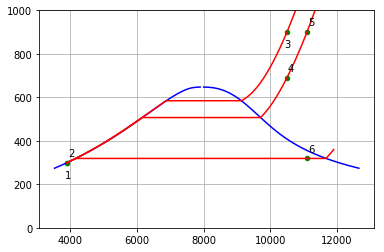

In [13]:
plot_water_curve(w)
plot_isobar(p_baja)
plot_isobar(p_media)
plot_isobar(p_alta)

plot_estado(estado1, offset=-70)
plot_estado(estado2, offset=30)
plot_estado(estado3, offset=-70)
plot_estado(estado4, offset=30)
plot_estado(estado5, offset=30)
plot_estado(estado6, offset=30)

plt.grid()
plt.show()